In [36]:
import warnings, os, datetime, zipfile, tqdm, gdown, glob, random, shutil, pytz
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [37]:
timezone = pytz.timezone('Europe/Paris')
now = datetime.datetime.now(timezone).strftime('%Y.%m.%d-%H.%M.%S')

project_path = os.getcwd()

is_docker = os.environ.get('IS_DOCKER', False)

if is_docker:
    print("Docker usage detected")
    project_path = f"{project_path}/livrable_2"
else:
    print("Normal usage detected")

paths = {
    "data_path": f"{project_path}/data",
    "train_data_path": f"{project_path}/data/train",
    "validation_data_path": f"{project_path}/data/validation",
    "unsorted_validation_data_path": f"{project_path}/data/validation/unsorted",
    "sorted_validation_data_path": f"{project_path}/data/validation/sorted",
    "model_path": f"{project_path}/models",
    "checkpoint_path": f"{project_path}/weights/model_early",
    "log_path": f"{project_path}/logs/fit/{now}_model"
}

paths_to_delete = [
    "unsorted_validation_data_path",
    "sorted_validation_data_path"
]

for key, path in paths.items():
    if key in paths_to_delete and os.path.exists(path):
        print(f"Deleting {path}")
        shutil.rmtree(path)
    os.makedirs(path, exist_ok=True)

image_h = 224
image_w = 224
batch_s = 24
encoding_dim = 256

Normal usage detected
Deleting C:\Users\lefra\Documents\Projets\ProjetDeepLearning\livrable_2/data/validation/unsorted
Deleting C:\Users\lefra\Documents\Projets\ProjetDeepLearning\livrable_2/data/validation/sorted


In [38]:
def download_dataset(force=False):
    
    dataset_path = f"{paths['train_data_path']}/dataset_livrable_2.zip"

    if os.path.exists(dataset_path) and force == False:
        print("Dataset already downloded")
    else:
        print("Downloading dataset")
        url = 'https://drive.google.com/uc?export=download&id=1WdcW_OqvRyuLiGx0FiZR0KmrqB9VYsLw'
        gdown.download(url, dataset_path, quiet=False)
    
    if len(os.listdir(paths['train_data_path'])) == 6 and force == False:
        print("Dataset already exported")
    else:
        print("Exporting dataset")
        with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
            files = zip_ref.infolist()
            with tqdm.tqdm(total=len(files), desc="Décompression", unit="fichier") as pbar:
                    for file in files:
                        zip_ref.extract(file, paths['train_data_path'])
                        pbar.update(1)
            zip_ref.extractall(paths['train_data_path'])
            print(f"Dataset downloaded {paths['train_data_path']}")
        
download_dataset()

Dataset already downloded
Exporting dataset


Décompression: 100%|██████████| 149/149 [00:00<00:00, 816.13fichier/s]


Dataset downloaded C:\Users\lefra\Documents\Projets\ProjetDeepLearning\livrable_2/data/train


In [39]:
def check_images_in_dataset(dataset_path):
    img_paths = glob.glob(os.path.join(dataset_path, '*/*.*'))

    for img_path in tqdm.tqdm(img_paths, desc="Checking images"):
        try:
            img_bytes = tf.io.read_file(img_path)
            tf.io.decode_image(img_bytes)

        except tf.errors.InvalidArgumentError as e:
            print(f"Found bad file: {img_path}. Removing it.")
            os.remove(img_path)

check_images_in_dataset(paths['train_data_path'])

Checking images: 100%|██████████| 148/148 [00:01<00:00, 104.64it/s]


In [56]:
train_set, test_set = tf.keras.preprocessing.image_dataset_from_directory(
    paths['train_data_path'],
    validation_split=0.2,
    subset="both",
    seed=42,
    image_size=(image_h, image_w),
    batch_size=batch_s,
    labels="inferred",
    label_mode="int"
)

Found 148 files belonging to 1 classes.
Using 119 files for training.
Using 29 files for validation.


ValueError: too many values to unpack (expected 2)

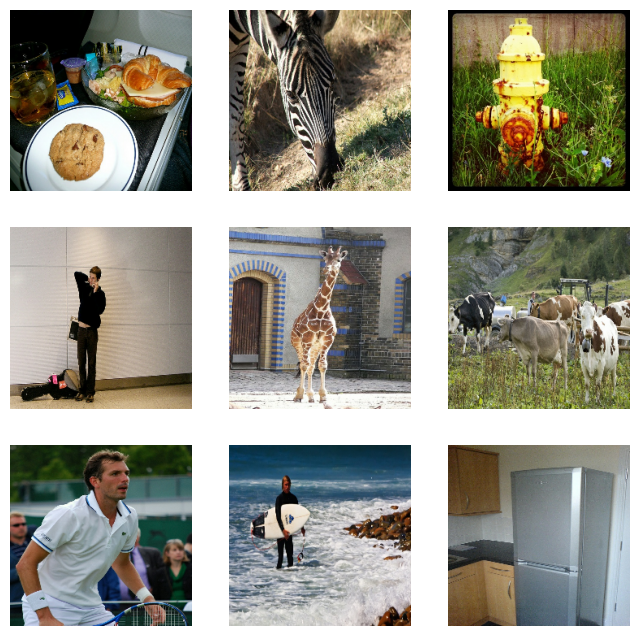

In [54]:
def print_img(dataset, num_images=9):
    plt.figure(figsize=(8, 8))
    for images, labels in dataset.take(1):
        for i in range(num_images):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.axis("off")
    plt.show()

print_img(train_set, 9)

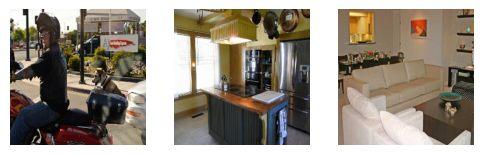

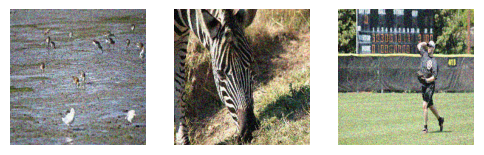

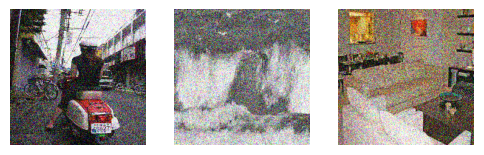

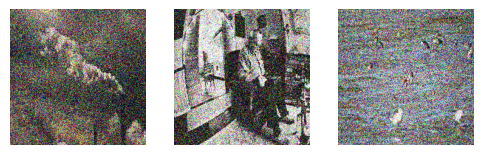

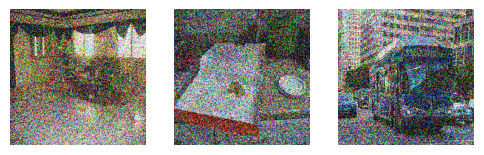

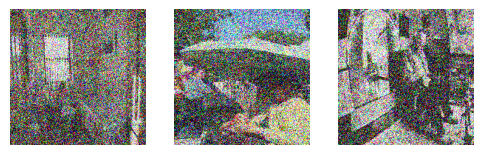

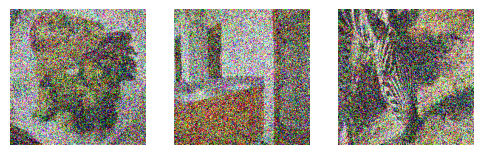

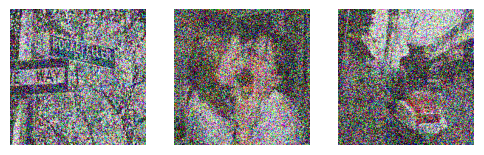

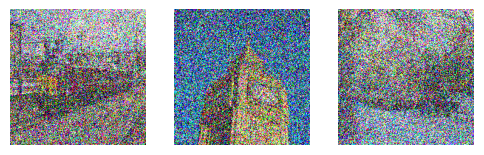

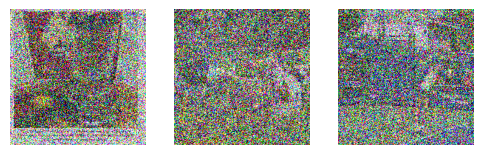

In [55]:
# Fonction pour ajouter du bruit et limiter les valeurs
def add_noise_to_images(dataset, noise_factor):
    noisy_images = []
    for image_batch, _ in dataset:
        image_batch = image_batch.numpy().astype('float32') / 255.
        noisy_batch = image_batch + np.random.normal(loc=0.0, scale=1.0, size=image_batch.shape) * noise_factor
        noisy_batch = np.clip(noisy_batch, 0., 1.)
        noisy_images.append(noisy_batch)
    return np.concatenate(noisy_images, axis=0)

# Ajouter du bruit à plusieurs niveaux et afficher les images bruitées
for noise_factor in np.arange(0, 1, 0.1):
    train_set_noisy = add_noise_to_images(train_set, noise_factor)
    test_set_noisy = add_noise_to_images(test_set, noise_factor)

    plt.figure(figsize=(6, 6))
    for i in range(3):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(train_set_noisy[i])
        plt.axis("off")
    plt.show()

In [27]:
def preprocess_image(image, label):
    image = tf.image.resize_with_pad(image, image_h, image_w)
    return image, label

train_set = train_set.map(preprocess_image)
test_set = test_set.map(preprocess_image)

In [29]:
AUTOTUNE = tf.data.AUTOTUNE
train_set = train_set.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_set = test_set.cache().prefetch(buffer_size=AUTOTUNE)

In [30]:
def create_autoencodeur(input_shape=(image_h, image_w, 3)):
    input_img = tf.keras.layers.Input(shape=input_shape)

    # Encoder
    x = tf.keras.layers.Flatten()(input_img)
    x = tf.keras.layers.Dense(encoding_dim, activation='relu')(x)
    
    # Decoder
    x = tf.keras.layers.Dense(np.prod(input_shape), activation='sigmoid')(x)
    decoded = tf.keras.layers.Reshape(input_shape)(x)
    
    # Modèle autoencodeur
    autoencoder = tf.keras.models.Model(input_img, decoded)

    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

    autoencoder.summary()

    return autoencoder

autoencoder = create_autoencodeur()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │    38,535,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 150528)         │    38,685,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 224, 224, 3)    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,221,120 (294.58 MB)

 Trainable params: 77,221,120 (294.58 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
def get_callbacks():
    # Create a callback that saves the model's weights
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=paths['checkpoint_path'] + "/weights-epoch-{epoch:02d}-{val_loss:.2f}.weights.h5",
        save_weights_only=True,
        save_best_only=True,
        verbose=1
    )

    # Tensorboard callback
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir=paths['log_path'],
        histogram_freq=1,
        write_graph=True,
        write_images=True,
        update_freq='epoch',
        profile_batch=0,
        embeddings_freq=0
    )

    # Early stopping
    early_callback = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0,
        patience=4,
        verbose=0,
        mode='auto',
        baseline=None,
        restore_best_weights=False,
        start_from_epoch=0
    )

    return [checkpoint_callback, tensorboard_callback, early_callback]

In [32]:
def run_model(model, epochs, load_path=None):
    if load_path is not None:
        model.load_weights(load_path)
        return False
    else:
        history = model.fit(
            train_set,
            epochs=epochs,
            validation_data=test_set,
            callbacks=get_callbacks()
        )
        model.save(f"{paths['model_path']}/model.keras")
        return history

history = run_model(
    autoencoder,
    epochs=10,
    # load_path=f"{paths['checkpoint_path']}/weights-epoch-19-0.31.weights.h5"
)

Epoch 1/10


ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(None,), output.shape=(None, 224, 224, 3)

In [33]:
for images, labels in train_set.take(1):
    print(f'Image batch shape: {images.shape}')
    print(f'Label batch shape: {labels.shape}')

Image batch shape: (23, 224, 224, 3)
Label batch shape: (23,)
